In [ ]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# # wordnet for lemmatization
# # nltk.download('wordnet') # run once
# # nltk.download('omw-1.4') # run once
# from nltk.stem import WordNetLemmatizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/triyuliannibasukie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseV

In [ ]:
df = pd.read_csv('cleaned_grab_playstore_reviews.csv')

In [ ]:
# Tokenize content with new column "Tokenised Content"
df['Tokenised Content']  = [word_tokenize(row) for row in df['Review']]

In [ ]:
# Remove stopwords of English and Indonesian

stop_words = stopwords.words('indonesian') + stopwords.words('english')
stop_words.remove('baik')
stop_words.remove('pantas')
stop_words.remove('masalah')
stop_words.remove('memerlukan')
stop_words.remove('diperlukan')

new_stop_words = ['grab', 'app', 'youe','po','jdi','go','u','jugak', 'smua','br','m','lol','condo','said','also',"click","expand","http","www","com","https",'from', 'subject', 're', 'edu', 'use',"lah","haha","#","%"]
stop_words.extend(new_stop_words)
#print(stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df['Removed Stopwords Content']  = df['Tokenised Content'].apply(lambda x: remove_stopwords(x))

In [ ]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN','ADJ','VERB', 'ADV']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df['Final Content'] = df['Removed Stopwords Content'].apply(lambda x: lemmatization(x))

df.head()

,Review,Score,Date,Tokenised Content,Removed Stopwords Content,Final Content
0,update poor performance taking minutes search ...,1,2023-02-11 08:54:07,"[update, poor, performance, taking, minutes, s...","[update, poor, performance, taking, minutes, s...","[update, poor, performance, take, minute, sear..."
1,bad app,1,2023-02-11 08:53:51,"[bad, app]",[bad],[bad]
2,friendly helpful nice well maintained vehicle ...,5,2023-02-11 08:40:39,"[friendly, helpful, nice, well, maintained, ve...","[friendly, helpful, nice, well, maintained, ve...","[friendly, helpful, nice, maintain, vehicle, e..."
3,remove grab app looking food knew car number w...,2,2023-02-11 08:23:40,"[remove, grab, app, looking, food, knew, car, ...","[remove, looking, food, knew, car, number, wai...","[remove, look, food, know, car, number, wait, ..."
4,embarassing singapore waiting time reduced min...,2,2023-02-11 08:16:02,"[embarassing, singapore, waiting, time, reduce...","[embarassing, singapore, waiting, time, reduce...","[embarasse, wait, time, reduce, minute, show, ..."


In [ ]:
df[df["Final Content"].str.len() == 0]

,Review,Score,Date,Tokenised Content,Removed Stopwords Content,Final Content
39,mabait si kuya,5,2023-02-10 18:00:33,"[mabait, si, kuya]","[mabait, si, kuya]",[]
68,huh,5,2023-02-10 07:40:29,[huh],[huh],[]
80,kita bantu mana org yg bawakan makan untuk kit...,5,2023-02-09 22:12:06,"[kita, bantu, mana, org, yg, bawakan, makan, u...","[bantu, org, yg, bawakan, makan, terbaik, ride...",[]
90,klo bisa pas setiap grabber sedia uang ratusan...,4,2023-02-09 19:32:49,"[klo, bisa, pas, setiap, grabber, sedia, uang,...","[klo, pas, grabber, sedia, uang, ratusan, rupiah]",[]
91,terbaik mcm dekat arab padu gaiss,5,2023-02-09 19:18:37,"[terbaik, mcm, dekat, arab, padu, gaiss]","[terbaik, mcm, arab, padu, gaiss]",[]
...,...,...,...,...,...,...
9721,duuhh lg dibutuhin urgent buat chat pusat bant...,1,2022-10-16 10:53:52,"[duuhh, lg, dibutuhin, urgent, buat, chat, pus...","[duuhh, lg, dibutuhin, urgent, chat, pusat, ba...",[]
9724,mantap kali,5,2022-10-16 10:15:37,"[mantap, kali]","[mantap, kali]",[]
9745,pengemudi sering banget gak mau jemput padahal...,1,2022-10-16 00:03:13,"[pengemudi, sering, banget, gak, mau, jemput, ...","[pengemudi, banget, gak, jemput, lokasi, jempu...",[]
9786,ok,5,2022-10-15 15:10:24,[ok],[ok],[]


In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df['Final Content'].values:
    description_str += ' '.join(row for row in word_list) + ' '

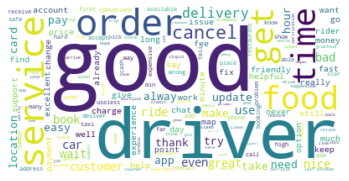

In [ ]:
new_stop_words = stopwords.words('indonesian') + stopwords.words('english')

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

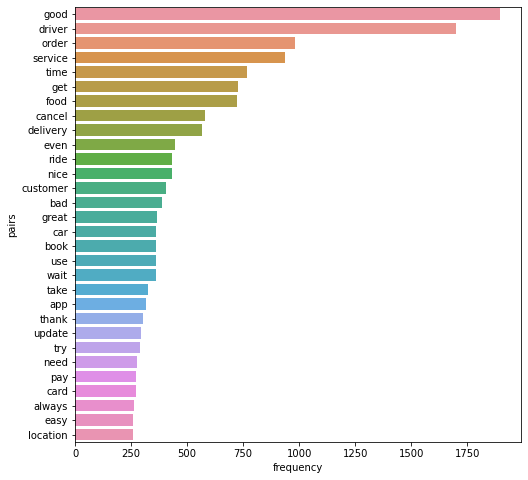

In [ ]:
new_tokens = []
for i in df['Final Content'].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

## Topic Modeling for Text

In [ ]:
# Create Corpus 
data_lemmatized = df['Final Content'].tolist()
print(data_lemmatized[:3])

[['update', 'poor', 'performance', 'take', 'minute', 'search', 'driver', 'loading', 'balance', 'grabpay', 'available'], ['bad'], ['friendly', 'helpful', 'nice', 'maintain', 'vehicle', 'enjoyable', 'ride']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'available'), (1, 'balance'), (2, 'driver'), (3, 'grabpay'), (4, 'loading'), (5, 'minute'), (6, 'performance'), (7, 'poor'), (8, 'search'), (9, 'take'), (10, 'update'), (11, 'bad'), (12, 'enjoyable'), (13, 'friendly'), (14, 'helpful'), (15, 'maintain'), (16, 'nice'), (17, 'ride'), (18, 'vehicle'), (19, 'accord'), (20, 'bed'), (21, 'bother'), (22, 'cancel'), (23, 'car'), (24, 'come'), (25, 'even'), (26, 'fine'), (27, 'food'), (28, 'ill'), (29, 'know'), (30, 'look'), (31, 'make'), (32, 'nervous'), (33, 'nowhere'), (34, 'number'), (35, 'order'), (36, 'remove'), (37, 'say'), (38, 'secure'), (39, 'surely'), (40, 'taxi'), (41, 'wait'), (42, 'way'), (43, 'business'), (44, 'charge'), (45, 'connect'), (46, 'damn'), (47, 'eat'), (48, 'get'), (49, 'least')]

Total Vocabulary Size: 2454


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [ ]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [ ]:
#our code
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.5119049844392094
Perplexity Score:  -6.425527533749245

topic number:  3
Coherence Score:  0.5288329538751388
Perplexity Score:  -6.46120580609484

topic number:  4
Coherence Score:  0.5833296473488766
Perplexity Score:  -6.496707032785558

topic number:  5
Coherence Score:  0.5812503749872238
Perplexity Score:  -6.551436339714505

topic number:  6
Coherence Score:  0.5095670117967575
Perplexity Score:  -6.584728372317915

topic number:  7
Coherence Score:  0.5363659976472464
Perplexity Score:  -6.610587437823943

topic number:  8
Coherence Score:  0.5444998325773199
Perplexity Score:  -6.6483834585626

topic number:  9
Coherence Score:  0.538879659924127
Perplexity Score:  -6.628571396883239

topic number:  10
Coherence Score:  0.557814355563809
Perplexity Score:  -6.665141866187136

topic number:  11
Coherence Score:  0.5575965907592291
Perplexity Score:  -6.65856415233646

topic number:  12
Coherence Score:  0.5546295824937927
Perplexity Score:  

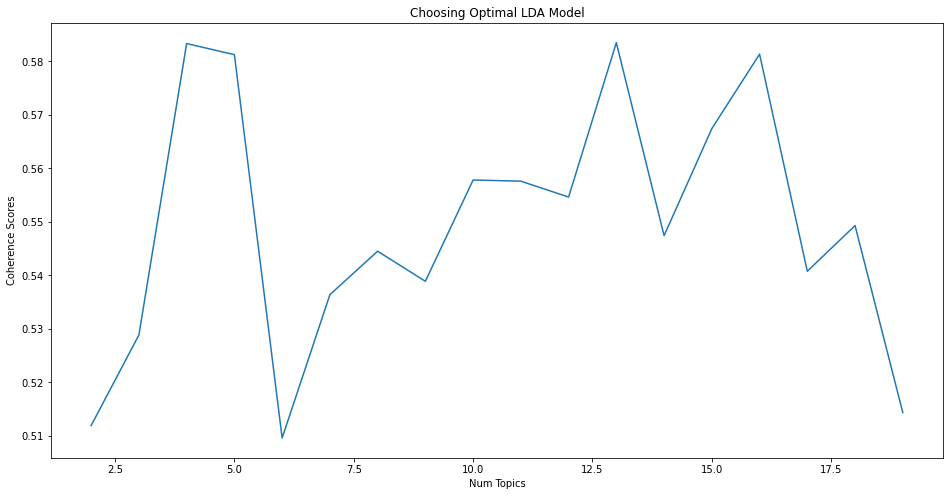

In [ ]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()
# We choose the highest coherence score reached before a major drop. K = 3


In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run - takes about 15 minutes with Apple M1
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████| 540/540 [52:12<00:00,  5.80s/it]


In [ ]:
df_1 = pd.read_csv('results/lda_tuning_results.csv')

In [ ]:
# chosen known alpha and beta values that yielded maximum coherence score for optimal K=4

# From the graph above, optimal number of topics is K=4
max_row = df_1[df_1['Topics'] == 4]

# Find the maximum coherence score
max_coherence = max_row.loc[max_row['Coherence'].idxmax()]
max_coherence

Validation_Set    100% Corpus
Topics                      4
Alpha                    0.01
Beta                     0.91
Coherence            0.636806
Name: 333, dtype: object

## Final LDA Model

In [ ]:
num_topics = 4


lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [ ]:
# Print the Keyword in the topics
print(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0, '0.046*"nice" + 0.038*"great" + 0.028*"easy" + 0.027*"friendly" + 0.026*"delivery" + 0.025*"fast" + 0.021*"driver" + 0.019*"helpful" + 0.015*"food" + 0.014*"map"'), (1, '0.017*"update" + 0.017*"card" + 0.013*"account" + 0.011*"try" + 0.011*"work" + 0.010*"payment" + 0.010*"use" + 0.009*"even" + 0.009*"time" + 0.008*"share"'), (2, '0.233*"good" + 0.050*"service" + 0.045*"driver" + 0.023*"thank" + 0.023*"excellent" + 0.013*"car" + 0.013*"safe" + 0.011*"ride" + 0.009*"clean" + 0.009*"job"'), (3, '0.035*"driver" + 0.030*"order" + 0.020*"get" + 0.019*"food" + 0.019*"time" + 0.018*"cancel" + 0.012*"bad" + 0.012*"delivery" + 0.011*"wait" + 0.011*"service"')]


In [ ]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [ ]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [ ]:
df['Topic'] = topic_num

In [ ]:
des_name_final = df[['Final Content', 'Topic']]
des_name_final

,Final Content,Topic
0,"[update, poor, performance, take, minute, sear...","[3, 1]"
1,[bad],[3]
2,"[friendly, helpful, nice, maintain, vehicle, e...",[0]
3,"[remove, look, food, know, car, number, wait, ...","[3, 1]"
4,"[embarasse, wait, time, reduce, minute, show, ...",[3]
...,...,...
9802,"[good, heaven, future, taxi, trip, arrangement...","[0, 2]"
9803,"[customer, service, nak, type, end, deduct, ko...",[1]
9804,"[helpful, service, fast, amazing, deliver, fas...",[0]
9805,"[try, book, ride, broad, daylight, specific, s...",[3]


In [ ]:
replacement_dict = {0: "Service", 1: "Online Payment & System", 2: "Transport", 3: "Ordering Process"}

# Apply the replacement dictionary to the 'LDA_Labelled_Topic' column
des_name_final['LDA_Labelled_Topic'] = des_name_final['Topic'].apply(lambda x: [replacement_dict[i] for i in x])
des_name_final

,Final Content,Topic,LDA_Labelled_Topic
0,"[update, poor, performance, take, minute, sear...","[3, 1]","[Ordering Process, Online Payment & System]"
1,[bad],[3],[Ordering Process]
2,"[friendly, helpful, nice, maintain, vehicle, e...",[0],[Service]
3,"[remove, look, food, know, car, number, wait, ...","[3, 1]","[Ordering Process, Online Payment & System]"
4,"[embarasse, wait, time, reduce, minute, show, ...",[3],[Ordering Process]
...,...,...,...
9802,"[good, heaven, future, taxi, trip, arrangement...","[0, 2]","[Service, Transport]"
9803,"[customer, service, nak, type, end, deduct, ko...",[1],[Online Payment & System]
9804,"[helpful, service, fast, amazing, deliver, fas...",[0],[Service]
9805,"[try, book, ride, broad, daylight, specific, s...",[3],[Ordering Process]


In [ ]:
des_name_final.to_csv("LDA_labelled_corpus.csv")

### Model Evaluation

In [ ]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -6.571955238775038
Coherence Score:  0.6220349667232972


### Visualisation

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.116564 -0.016403       1        1  52.632566
1      0.142734  0.094731       2        1  23.362628
0     -0.040407 -0.161103       3        1  12.936777
2     -0.218892  0.082776       4        1  11.068029, topic_info=            Term         Freq        Total Category  logprob  loglift
65          good  1384.000000  1384.000000  Default  30.0000  30.0000
2         driver  1417.000000  1417.000000  Default  29.0000  29.0000
75       service   738.000000   738.000000  Default  28.0000  28.0000
16          nice   318.000000   318.000000  Default  27.0000  27.0000
64         great   269.000000   269.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
14       helpful    33.974250   166.777529   Topic4  -5.1643   0.6101
563  application    20.933158    54.676830   Topic4  -5.6486   1.2410
136       person    16.868351    38.967935   Topic4  -5.8645   1.3638
289         slow    17.491107    55.074508   Topic4  -5.8282   1.0541
383         much    17.547471   151.333728   Topic4  -5.8250   0.0465

[245 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
459       1  0.925316   accept
459       2  0.068038   accept
459       3  0.006804   accept
459       4  0.006804   accept
151       1  0.053277  account
...     ...       ...      ...
321       4  0.004486     work
144       1  0.931437    worst
144       2  0.029107    worst
144       3  0.029107    worst
144       4  0.029107    worst

[772 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

## Word Count of Key Topics 

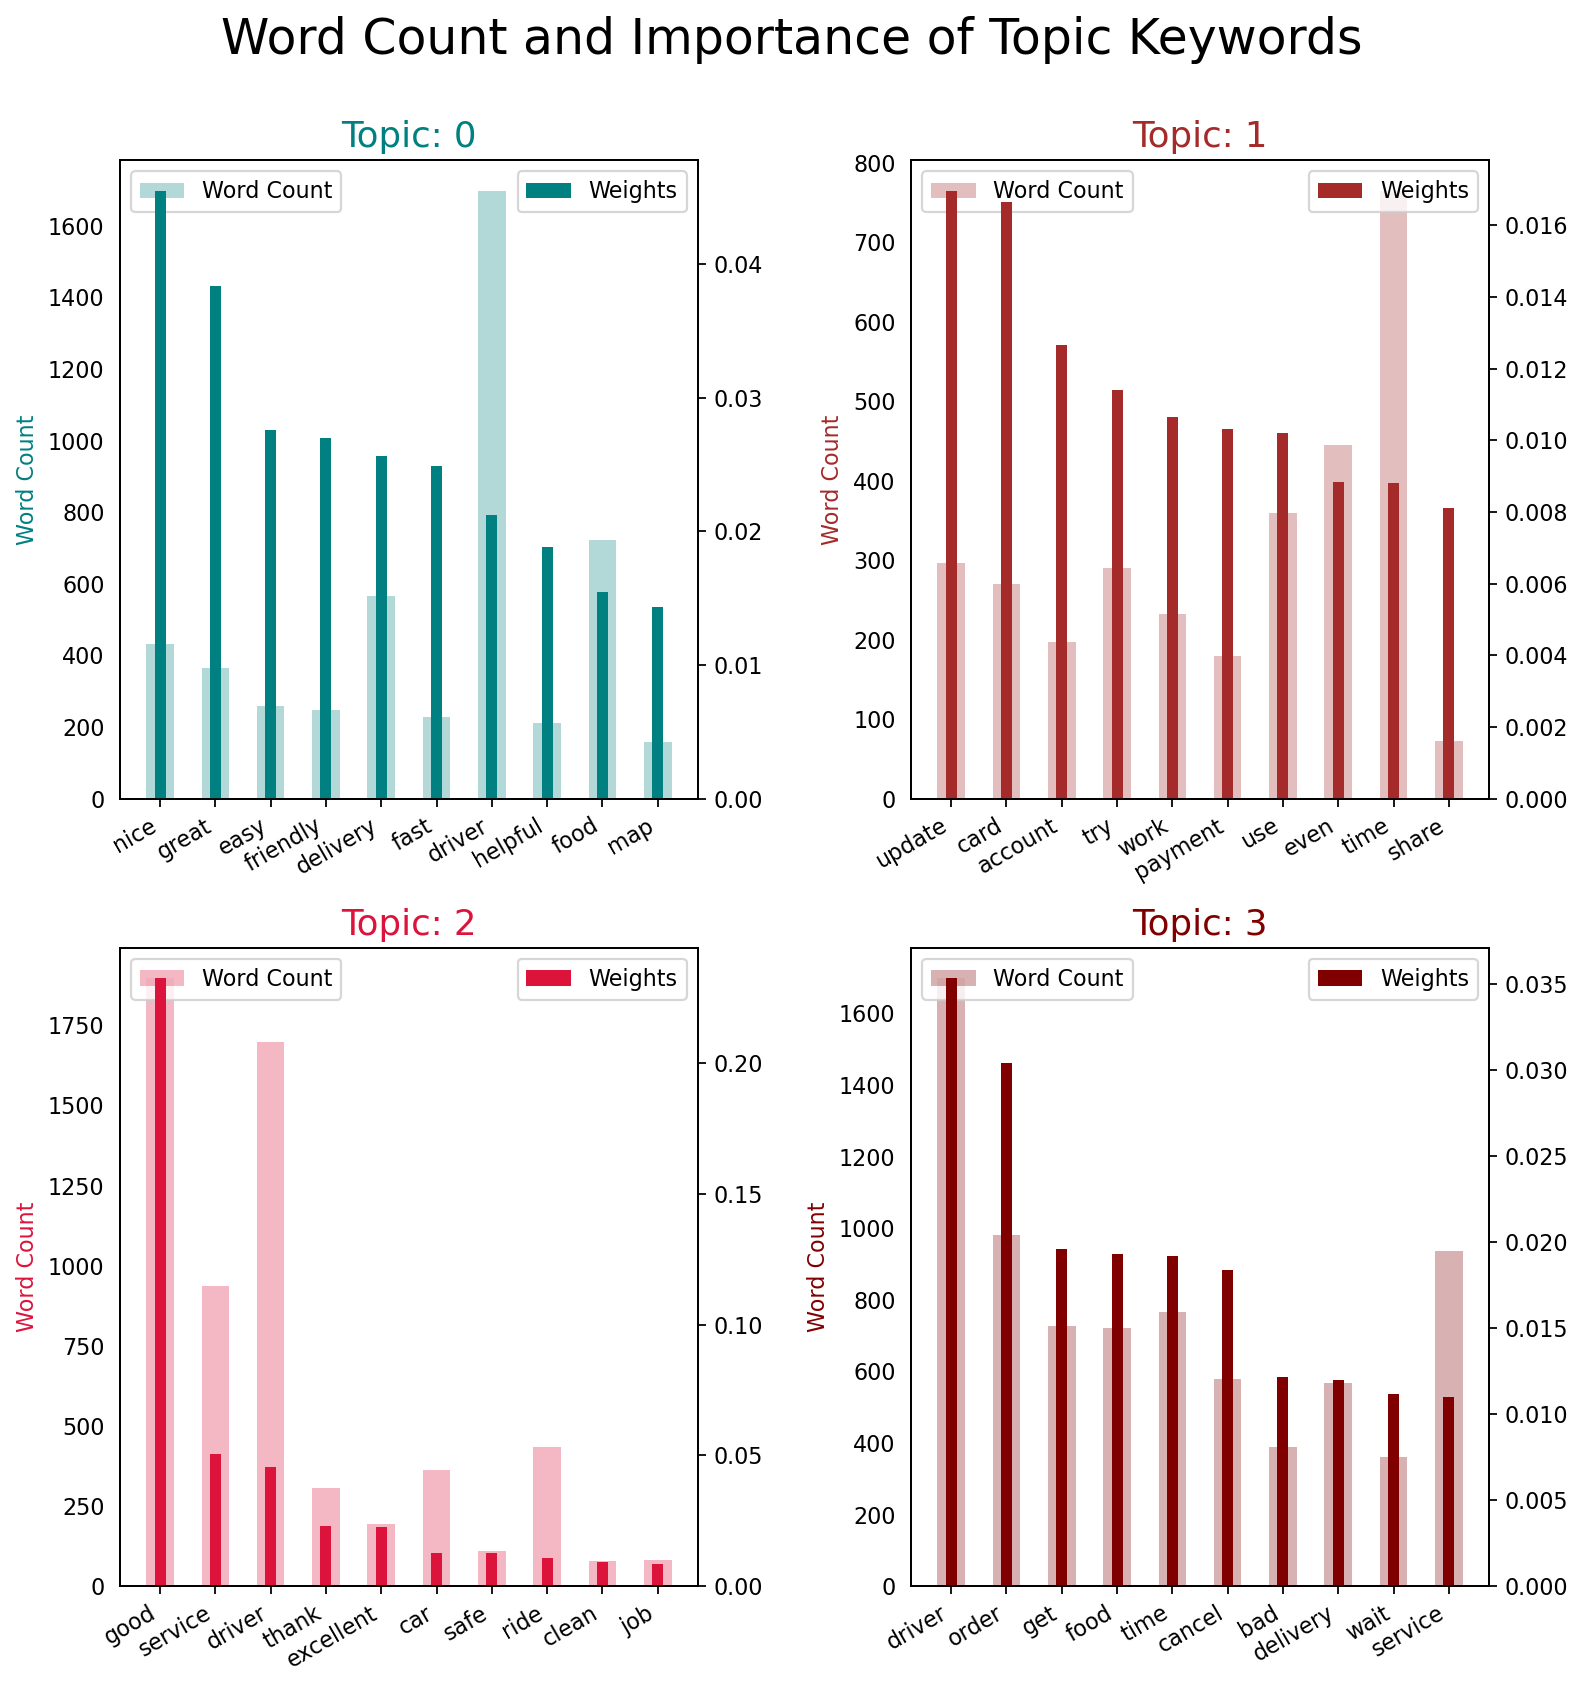

In [ ]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=num_topics, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(10,10), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > num_topics - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()